<a href="https://colab.research.google.com/github/antoinebachand/Derivatives-and-risk-management/blob/main/Dimension_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dimension Reduction
# Derivatives and Risk Management
# Author: Antoine Bachand

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb 

from sklearn.metrics import r2_score
from sklearn import linear_model

In [ ]:
# Import the Adj close
df = pd.read_excel('Adj_data.xlsx', header=0, index_col=False, keep_default_na=True)

# Create the returns series
returns = (np.log(df).diff()).dropna()

In [ ]:
# First lets see the correlation of the data
returns.corr()

,INTC,MSFT,IBM,MCD,WMT,DIS,^DJI
INTC,1.000000,0.531709,0.356435,0.187476,0.223980,0.214851,0.407465
MSFT,0.531709,1.000000,0.328527,0.224868,0.279060,0.261736,0.457130
IBM,0.356435,0.328527,1.000000,0.204807,0.201436,0.195959,0.477094
MCD,0.187476,0.224868,0.204807,1.000000,0.264647,0.256571,0.479196
WMT,0.223980,0.279060,0.201436,0.264647,1.000000,0.281248,0.486493
DIS,0.214851,0.261736,0.195959,0.256571,0.281248,1.000000,0.513085
^DJI,0.407465,0.457130,0.477094,0.479196,0.486493,0.513085,1.000000


#Covariance of the data
The previous table shows the covariance matrix of the different stocks. We notice that the highest covariance is between Intel and Microsoft. 

#Factor Model

In [ ]:
# Create the regression function ( The for loop applies the regression to all stocks)

def beta():
  Beta = []
  r_square = []
  error = pd.DataFrame({})  # empty df
  stock_list = ['INTC', 'MSFT', 'IBM', 'MCD', 'WMT', 'DIS']
  for i in stock_list:
    # Model (Beta)
    reg = np.polyfit(returns['^DJI'], returns[i],deg = 1)
    Beta.append(reg[0]) # Adds only the Beta
    # R2
    r2 = r2_score(returns[i], returns['^DJI'])
    r_square.append(r2)
    # Error 
    prediction = (returns['^DJI']*reg[0])+reg[1] # prediction from the beta and intercept
    e = prediction - returns[i]
    error[i] = e  # Adds the error columns to the df

  table = pd.DataFrame({"Beta": Beta, "r_square": r_square})
  table.index = [stock_list]
  display(table)
  display(error.corr()) # Cov of the error df
  
beta()

,Beta,r_square
INTC,1.120860,0.162000
MSFT,1.109366,0.204974
IBM,1.071722,0.226386
MCD,0.858034,0.223161
WMT,1.019169,0.236591
DIS,1.028865,0.263037


,INTC,MSFT,IBM,MCD,WMT,DIS
INTC,1.000000,0.425309,0.201892,-0.009706,0.032274,0.007383
MSFT,0.425309,1.000000,0.141282,0.007446,0.072928,0.035616
IBM,0.201892,0.141282,1.000000,-0.030872,-0.039940,-0.064733
MCD,-0.009706,0.007446,-0.030872,1.000000,0.041105,0.014207
WMT,0.032274,0.072928,-0.039940,0.041105,1.000000,0.042185
DIS,0.007383,0.035616,-0.064733,0.014207,0.042185,1.000000


#Single factor model analysis
First, except for the Microsoft error term, the covariance of the error terms is more or less equal to zero. Thus, our model respects the assumptions of a factor model. However, the performance or accuracy of our model is relatively low. Indeed, our r square terms vary for the different stocks from 0.162 for Intel to 0.263 for Disney. Thus, using the Dow Jones as the only factor does not present a good accuracy (it is a weak model).  

# PCA

In [ ]:
#Data preparation (For this section we dont need the DOW)
df = returns.drop(['^DJI'],axis=1)

# Covariance Matrix
cov = np.cov(df.T)

In [ ]:
# Principal component
eig_vals,eig_vecs = np.linalg.eig(cov)
# Creat clean df
data = {'INTC': eig_vecs[0], 'MSFT': eig_vecs[1], 'IBM':eig_vecs[2],'MCD':eig_vecs[3],'WMT':eig_vecs[4],'DIS':eig_vecs[5]}
dfe = pd.DataFrame(data)
dfe.index = ['Eigen 1', 'Eigen 2', 'Eigen 3', 'Eigen 4', 'Eigen 5', 'Eigen 6']

df_2PCA = dfe.drop(['Eigen 3', 'Eigen 4', 'Eigen 5', 'Eigen 6']) # Print just the first two vectors
display(df_2PCA)

,INTC,MSFT,IBM,MCD,WMT,DIS
Eigen 1,-0.636874,-0.529765,-0.371244,-0.193455,-0.276607,-0.248963
Eigen 2,-0.512041,-0.103423,0.067493,0.350862,0.593009,0.497794


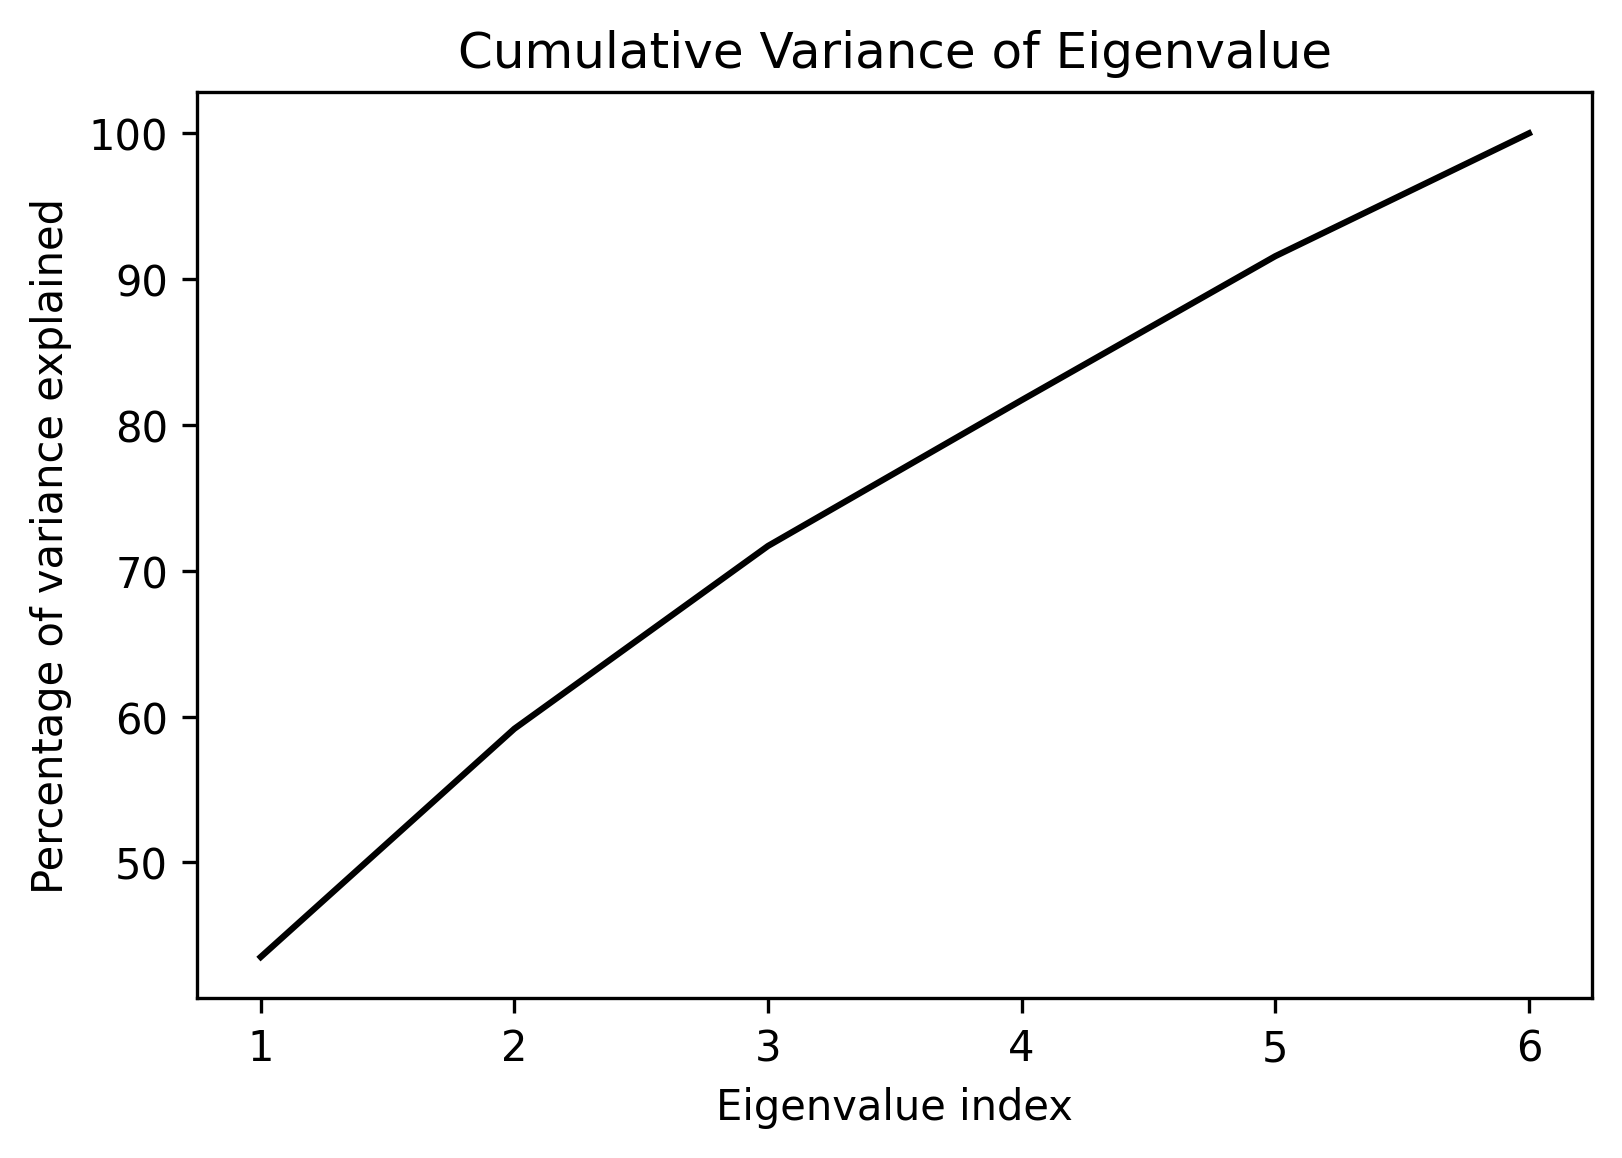

[ 43.52086201  59.17186043  71.70618819  81.70516016  91.57675769
 100.        ]


In [ ]:
# Percentage of variance  
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

def _plot_cum_variance():
    plt.plot([1,2,3,4,5,6],cum_var_exp, 'k')
    plt.title('Cumulative Variance of Eigenvalue')
    plt.xlabel('Eigenvalue index')
    plt.ylabel('Percentage of variance explained')
    plt.gcf().set_dpi(300)
    plt.show()
_plot_cum_variance()
print(cum_var_exp)

# Graphical analysis
This last graph shows the total percentage of variance that is explained by a number of factors. We notice that our first factor explains 43.52% of the variance and cumulatively our two factors explain 59.17% of the variance   

In [ ]:
# Now lets do the model with Sklearn 
from sklearn.decomposition import PCA

X = df
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_) # We get the same variance we add early

[0.43520862 0.15650998]


In [ ]:
# Now we do the PCA Transform 
y = pca.transform(X)
# Residuals of the model
reconstruct = pca.inverse_transform(y)
residual= X - reconstruct  

def r2():
  regr = linear_model.LinearRegression() 
  # Fit 
  regr.fit(y, X) 
  # Calibration 
  y_c = regr.predict(y)
  r_square = [] 
  pred = pd.DataFrame(y_c, columns=['INTC', 'MSFT', 'IBM', 'MCD', 'WMT', 'DIS'])
  stock_list = ['INTC', 'MSFT', 'IBM', 'MCD', 'WMT', 'DIS']
  for i in stock_list:
    r2 = r2_score(X[i], pred[i])
    r_square.append(r2)
  table = pd.DataFrame({"r_square": r_square})
  table.index = [stock_list]
  display(table)

# Print the full Table  
display(df_2PCA)
r2()
residual.corr()

,INTC,MSFT,IBM,MCD,WMT,DIS
Eigen 1,-0.636874,-0.529765,-0.371244,-0.193455,-0.276607,-0.248963
Eigen 2,-0.512041,-0.103423,0.067493,0.350862,0.593009,0.497794


,r_square
INTC,0.865939
MSFT,0.633194
IBM,0.362262
MCD,0.334000
WMT,0.606224
DIS,0.492543


,INTC,MSFT,IBM,MCD,WMT,DIS
INTC,1.000000,-0.758323,-0.406087,0.105533,0.311886,0.214286
MSFT,-0.758323,1.000000,-0.285996,-0.090875,-0.110203,-0.101177
IBM,-0.406087,-0.285996,1.000000,-0.087446,-0.248800,-0.190116
MCD,0.105533,-0.090875,-0.087446,1.000000,-0.358916,-0.255531
WMT,0.311886,-0.110203,-0.248800,-0.358916,1.000000,-0.592529
DIS,0.214286,-0.101177,-0.190116,-0.255531,-0.592529,1.000000


# Summary analysis of the models
With this last method (PCA) we notice that the correlation of the actual and predicted values is much higher (r_square) than the Single Factor Model. Although this method is more efficient and accurate, it still has some disadvantages. First, the two factors used are purely statistical. It is therefore difficult to express what the factors represent. It is also difficult to represent a scenario with, for example, 5% inflation or a high interest rate environment.  It would be necessary to obtain new data and we would obtain different factors and a different model.  

Secondly, we can see that the model derived from the PCA does not meet the assumptions of a factor model. Indeed, we notice in the last data frame that the errors present a correlation (the covariance between the error terms is not equal to 0). Although the model is hence not a factor model, this correlation is not dramatic or important. Indeed, the terms correspond to the 4 other principal directions which explain 40.83% of the variance. Therefore, they are certainly correlated. 
